In [1]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Tracker, EventGenerator, PadPlane, Minimizer
from pytpc.constants import *
import pytpc.simulation
import pytpc.tpcplot
import pytpc.vmedata
from pytpc.cleaning import HoughCleaner
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import scipy.signal
import h5py
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.optimize import differential_evolution, minimize, basinhopping, leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
#import cmaps
import yaml
from scipy.fftpack import fft, ifft, fftshift, ifftshift
from copy import copy, deepcopy
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/chen/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
with open('/home/chen/ar46/config/config_e15503b_p.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)

In [3]:
tilt = config['tilt'] * degrees 
#clock = config['clock']
#beam_en = config['beam_enu0']
padplane = mcfitter.padplane
efield = np.array(config['efield'])
bfield = np.array(config['bfield'])
#tmat = pytpc.utilities.tilt_matrix(-tilt)
# efield_uvw = tmat.dot(efield)
# bfield_uvw = tmat.dot(bfield)
mass_num = config['mass_num']
charge_num = config['charge_num']
gas = pytpc.gases.InterpolatedGas(config['gas_name'], config['gas_pressure'])
beam_enu0 = config['beam_enu0']
beam_charge = config['beam_charge']
beam_mass = config['beam_mass']
max_en = config['tracker_max_en']
vd = np.array(config['vd'])
max_beam_angle = (config['max_beam_angle']*math.pi)/180
beam_origin_z = config['beam_origin_z']
#beampads = np.fromfile(config['beampads_path'], sep=',', dtype='int')

In [76]:
#Good events for are: 34
full = h5py.File('/home/chen/ar46/clean_events/clean_run_0106.h5', 'r')
evt_ID = 34
dataset_name = '/clean'
evt_full = full[dataset_name]
print(len(evt_full))
xyzs_h5 = evt_full[str(evt_ID)]

xyzs = np.array(xyzs_h5)

#delete the points which are farther away from the center of the spiral
del_list = []

for i in range(len(xyzs)):
    if (xyzs[i,6]) > 75.0:
        del_list.append(i)
cut_xyzs = np.delete(xyzs,del_list,axis=0)

28696


In [77]:
xy = xyzs[:, 0:2]
xy_C = np.ascontiguousarray(xy, dtype=np.double)
cx, cy = pytpc.cleaning.hough_circle(xy_C)
print(cx,cy) #The center of curvature of the track, in mm.

cut_xy = cut_xyzs[:, 0:2]
cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)

50.9035455230047 -80.21115292269143


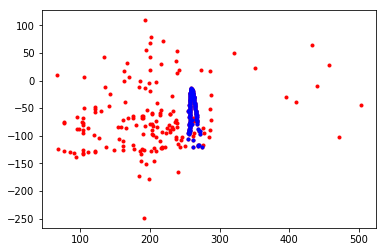

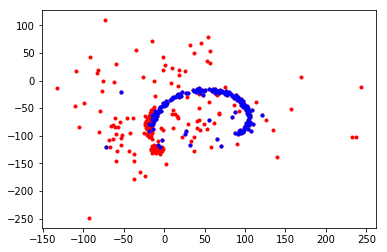

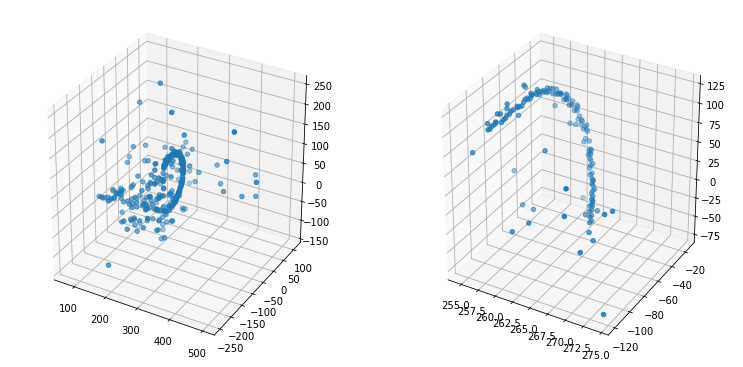

In [78]:
%matplotlib inline
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 2], cut_xyzs[:, 1], 'b.')
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 0], cut_xyzs[:, 1], 'b.')
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(xyzs[:,2],xyzs[:,1],xyzs[:,0])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(cut_xyzs[:,2],cut_xyzs[:,1],cut_xyzs[:,0])

In [79]:
%%time
uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False) # get calibrated set of data
uvw_values = uvw.values #transform pd file to arrays
mcres, minChis, all_params, good_param_idx = mcfitter.process_event(uvw, cu, cv, return_details=True)

print(mcres)

{'x0': 0.002609424611875495, 'y0': 0.0012888409894898302, 'z0': 1.052568625202726, 'enu0': 0.9858651967990767, 'azi0': -4.4124729164592145, 'pol0': 1.026409899810584, 'posChi2': 90.36168835516244, 'enChi2': 2.838102862351988, 'vertChi2': 0.16940415802501405, 'lin_scat_ang': 2.031144707779363, 'lin_beam_int': 1083.060671729134, 'lin_chi2': 46188.42149391329, 'rad_curv': 67.21464735433692, 'brho': 0.12604184324022644, 'curv_en': 0.7608728850575034, 'curv_ctr_x': 50.9035455230047, 'curv_ctr_y': 28.892769357179162}
CPU times: user 10.8 s, sys: 316 ms, total: 11.1 s
Wall time: 638 ms


In [80]:
%%time
cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False) # get calibrated set of data
cut_uvw_values = cut_uvw.values #transform pd file to arrays
cut_mcres, cut_minChis, cut_all_params, cut_good_param_idx = mcfitter.process_event(cut_uvw, cut_cu, cut_cv, return_details=True)
print(cut_mcres)


{'x0': 4.898963226119746e-05, 'y0': -0.01447118678504534, 'z0': 1.1072409715045062, 'enu0': 0.9245740181075326, 'azi0': -4.272671496752394, 'pol0': 1.7972742383294362, 'posChi2': 11.651198967228465, 'enChi2': 4.749562402143698, 'vertChi2': 4.188352939034799, 'lin_scat_ang': 1.6061178030595062, 'lin_beam_int': 1093.442810157829, 'lin_chi2': 54.33371340303038, 'rad_curv': 51.57884300832177, 'brho': 0.08670653845938278, 'curv_en': 0.3600694813328553, 'curv_ctr_x': 50.9035455230047, 'curv_ctr_y': 28.892769357179162}
CPU times: user 9.19 s, sys: 372 ms, total: 9.56 s
Wall time: 538 ms


In [81]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(mcres['x0'], mcres['y0'], mcres['z0'], mcres['enu0'], mcres['azi0'], mcres['pol0'])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
# drift_vel=-2.54, clock=12.5, 

cut_evtClean, cut_ctr = sim.make_event(cut_mcres['x0'], cut_mcres['y0'], cut_mcres['z0'], cut_mcres['enu0'], cut_mcres['azi0'], cut_mcres['pol0'])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [74]:
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values

cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values

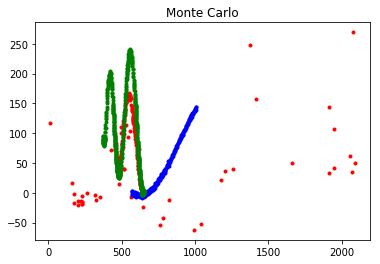

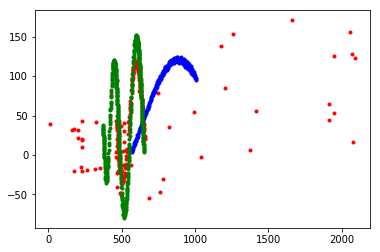

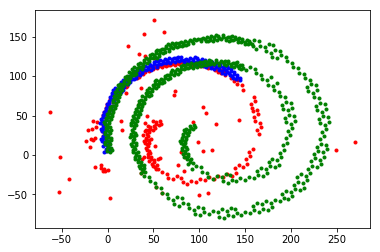

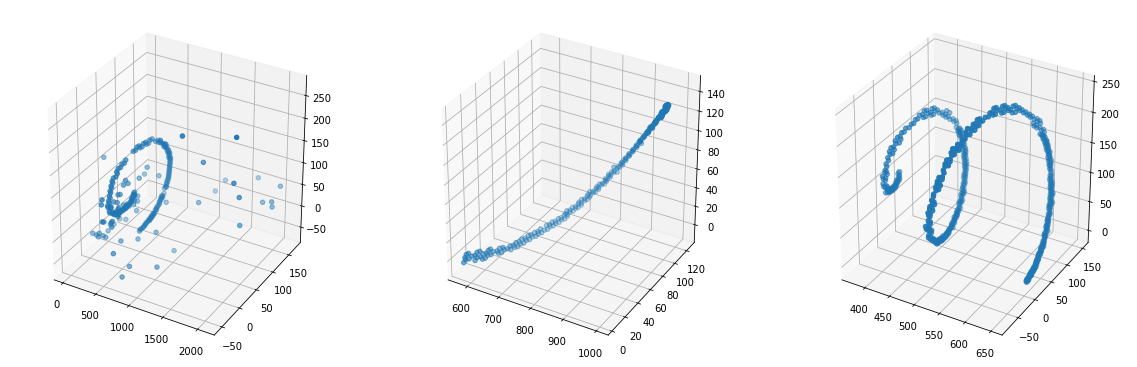

In [75]:
%matplotlib inline
plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.')
plt.title("Monte Carlo")
plt.show()
plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.')
plt.show()
plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.')
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])